# Model-asisted Labeling with YOLOv5
> custom image set annotation with a model's help

![base64 splash](https://github.com/PhilBrockman/ModelAssistedLabel/blob/master/modelassistedlabel%20splash.jpg?raw=true)

## Background

My exercise equipment, despite even being electronic, doesn’t connect to a network.

But if I instead point my webcam at the equipment’s LCD output, I can make a machine learn to identify and interpret useful information. Perfect! I’ll just utilize object detection to determine the location and identity of the machine’s analog readout. 

First question, just a tiny one, how do you do that?  

After wading through several guides, I found [Roboflow's YOLOv5 tutorial]( https://models.roboflow.com/object-detection/yolov5). They helped provide a hands-on and accessible experience in machine learning.

Unfortunately, I didn't have much luck with existing models being able to readily parse digits. Instead, I decided to start building my own dataset.

I shouldn't have been caught off-guard by the tedium of manually annotating images. As my mind starts to drift, I wonder if I’m a reCAPTCHA interface that’s gained sentience, and I break through. If I label enough digits, I can train a YOLO model to tell me what it sees. I can then take that information and pre-label my images with those predictions. 

The pieces come together.  I can focus on writing code while I use Roboflow to sort, generate, and deliver my images. I sleuth through [Ultralytic's](https://github.com/ultralytics/yolov5) original project and build wrappers around the essential functions in `detect.py` and `train.py`.

This repository contains the tools that let me "pre-label" my images before sending them off for human inspection and correction.

I need two inputs:
* Either:
  + a set of YOLOv5 weights 
  + or a repository of ".jpg" images and ".txt" labels.
* And:
  + a folder with unlabeled images

> Note: In `./Image Repo` I provide access to 841 labeled images (lumped in one folder) and 600 unlabeled images (seperated into three sets of 200 images - lighting condition is the same within each run, but differs between runs). 





## Getting Started

> Tip: [Open In Colab](https://colab.research.google.com/github/PhilBrockman/ModelAssistedLabel/blob/master/index.ipynb)

In [ ]:
# clone this repository
!git clone https://github.com/PhilBrockman/ModelAssistedLabel.git
%cd "ModelAssistedLabel"

### Expected Inputs:

-  **labeled images**
    + All of the images and labels must be in a common folder (subfolders allowed).
    + Labels must be in [YOLOv5 format](https://github.com/AlexeyAB/Yolo_mark/issues/60#issuecomment-401854885).

    > Note: Image/label pairs are based on their base filename. For example `image.jpg/image.txt` would be paired as would `other_image5.jpg/other_image5.txt`.






In [ ]:
# these images have already been labeled
labeled_images   = "Image Repo/labeled/Final Roboflow Export (841)"

  - **unlabeled images**

In [ ]:
# these images need to be labeled
unlabeled_images = "Image Repo/unlabeled/21-3-22 rowing (200) 1:53-7:00"

### Expected Output:

* **Folder** that contains: 
    - `images/`
      + a copy of every image in **Unlabeled Data**
    - `labels/`
      + result of running object detection on each image
    - a results folder produced by Ultralytic's `train.py` on the **Labeled Data** (if not using pre-trained weights)
    - `class labels.txt` to preserve the identity of the classes


In [ ]:
from ModelAssistedLabel.config import Defaults
import os

project_name = "seven segment digits - "
export_folder = Defaults._itername(project_name)

print(export_folder)

seven segment digits - 1


In [ ]:
# make the export folder
os.mkdir(export_folder)

# make the images and labels subfolders
for resource_folder in ["images", "labels"]:
  os.mkdir(os.path.join(export_folder, resource_folder))

## Configure defaults

Several values are stored by the `Defaults` class. Any value can be overridden (and new values can be added. Make sure to `save()` any changes!

In [ ]:
d = Defaults()
print(" -- Defined Keys: --")
print("\n".join([x for x in d.__dict__.keys()]))

 -- Defined Keys: --
config_file
root
split_ratio
data_yaml
resource_map
trainer_template


Speciy the absolute path of the root directory.

In [ ]:
!pwd

/content/drive/My Drive/Coding/ModelAssistedLabel


In [ ]:
d.root = "/content/ModelAssistedLabel/"

Save any changes and enter root directory

In [ ]:
d.save()
d.to_root()

moving to /content/drive/MyDrive/Coding/ModelAssistedLabel/


I borrow the instructions to set up the Ultralytics repo from [the Roboflow tutorial]( https://models.roboflow.com/object-detection/yolov5). (If I'd be allowed one undo on this project, I wish I would have intially forked this project from that tutorial.)

In [ ]:
# clone YOLOv5 repository
!git clone https://github.com/ultralytics/yolov5  # clone repo

%cd yolov5
# install dependencies as necessary
!pip install -qr requirements.txt  # install dependencies (ignore errors)
import torch

from IPython.display import Image, clear_output  # to display images
from utils.google_utils import gdrive_download  # to download models/datasets
%cd ..

/content/drive/My Drive/Coding/ModelAssistedLabel/yolov5
     |████████████████████████████████| 645kB 15.9MB/s 
/content/drive/My Drive/Coding/ModelAssistedLabel


Make sure GPU is enabled.

In [ ]:
if torch.cuda.is_available():
  print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) ))
  d.to_root() #step up a level
else:
   raise Exception("enable GPU")

Setup complete. Using torch 1.8.0+cu101 _CudaDeviceProperties(name='Tesla P100-PCIE-16GB', major=6, minor=0, total_memory=16280MB, multi_processor_count=56)
moving to /content/drive/MyDrive/Coding/ModelAssistedLabel/


## Processing input

Next, the images need to be written in a way so that the Ultralytics repository can understand their content. The `Autoweights` class both organizes data and create weights. Running an "initialize" command makes changes to the disk.

In [ ]:
from ModelAssistedLabel.train import AutoWeights

#location to store anything that needs to be written to disk
datadump="tmp/"

#configure a basic AutoWeights class instance
aw = AutoWeights(name=export_folder, out_dir=datadump)

# create train/valid/test split from a bag of labeled images (recusively seek out images/labels)
aw.initialize_images_from_bag(bag_of_images_and_labels = labeled_images)

# see the sizes of the train/valid/test groups
aw.traverse_resources()


dirs ['./train', './valid', './test']
yaml ipynb_tests/indexdump/autoweights/Final Roboflow Export (841)<index auto weights> 21-03-26 16-39-59/data.yaml
subdir train
	outdir ipynb_tests/indexdump/autoweights/Final Roboflow Export (841)<index auto weights> 21-03-26 16-39-59
subdir valid
	outdir ipynb_tests/indexdump/autoweights/Final Roboflow Export (841)<index auto weights> 21-03-26 16-39-59
subdir test
	outdir ipynb_tests/indexdump/autoweights/Final Roboflow Export (841)<index auto weights> 21-03-26 16-39-59
os.listdir ['train', 'valid', 'test', 'data.yaml']
mv 'unzipped/ipynb_tests/indexdump/autoweights/Final Roboflow Export (841)<index auto weights> 21-03-26 16-39-59/train' .
mv 'unzipped/ipynb_tests/indexdump/autoweights/Final Roboflow Export (841)<index auto weights> 21-03-26 16-39-59/valid' .
mv 'unzipped/ipynb_tests/indexdump/autoweights/Final Roboflow Export (841)<index auto weights> 21-03-26 16-39-59/test' .
mv 'unzipped/ipynb_tests/indexdump/autoweights/Final Roboflow Export

## Generate Weights

With the images written to disk, we can run the Ultralytics training algorithm. I loved watching the progress fly by in real time on the original `train.py`. Fortunately, the Ultralytics folk write the results file to disk so the model's training data is still accessible!

In [ ]:
%%time
aw.generate_weights(2000)

CPU times: user 43.5 s, sys: 4.84 s, total: 48.3 s
Wall time: 3h 46min 43s


'yolov5/runs/train/<index auto weights>/'

The results folder is stored as an attribute as well, and it has a lot of data stored therein.

In [ ]:
import os
aw.last_results_path, len(os.listdir(aw.last_results_path))

('yolov5/runs/train/<index auto weights>/', 22)

However, the weights are stored in a subfolder called (aptly) "weights".

In [ ]:
os.listdir(aw.last_results_path + "/weights")

['last.pt', 'best.pt']

View the last couple lines 

In [ ]:
with open(aw.last_results_path + "/results.txt") as results_file:
  results = results_file.readlines()
print("Epoch   gpu_mem       box       obj       cls     total    labels  img_size")
results[-5:]

Epoch   gpu_mem       box       obj       cls     total    labels  img_size


[' 1995/1999      1.8G    0.0231   0.01575  0.006738   0.04559       124       416    0.9932    0.9917    0.9938    0.8766   0.02019   0.01382  0.005234\n',
 ' 1996/1999      1.8G   0.02331   0.01637  0.006541   0.04622       158       416    0.9932    0.9917    0.9938    0.8763   0.02019   0.01386  0.005235\n',
 ' 1997/1999      1.8G     0.024   0.01509  0.007179   0.04626       158       416    0.9932    0.9917    0.9938    0.8764   0.02019   0.01383  0.005234\n',
 ' 1998/1999      1.8G   0.02421   0.01669  0.007122   0.04802        97       416    0.9932    0.9917    0.9938    0.8762   0.02019   0.01383  0.005234\n',
 ' 1999/1999      1.8G   0.02361   0.01668  0.007164   0.04745       199       416    0.9932    0.9917    0.9938    0.8763   0.02019   0.01386  0.005235\n']

## Labeling a new set of images

The names of my classes are digits. Under the hood, the YOLOv5 model is working of the index of the class, rather than the human-readable name. Consequently, the identities of each class index must be supplied.

In [ ]:
class_idx = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '0']

And the `Viewer` class doesn't care how recently your weights were generated so you can plug in existing weights.

In [ ]:
from ModelAssistedLabel.detect import Viewer

# access the folder of results from the AutoWeights instance
results_folder = aw.last_results_path

# I'm choosing to use the best weight.
weight_path = results_folder + "/weights/best.pt"

# Viewer needs a set of weights and an array of labels for the detected object types
v = Viewer(weight_path, class_idx)

Fusing layers... 


Selects all images in the unlabeled folder and let's us look through the computer's eyes at the images.

image 1/1 /content/drive/MyDrive/Coding/ModelAssistedLabel/Image Repo/unlabeled/21-3-22 rowing (200) 1:53-7:00/144.jpg: >>> [{'predictions': ['2 0.465234 0.260417 0.0195312 0.0819444 0.678878', '4 0.439844 0.254167 0.0203125 0.0833333 0.867007', '9 0.414453 0.252778 0.0226563 0.0833333 0.873467', '4 0.488281 0.263889 0.0203125 0.0833333 0.885513']}]


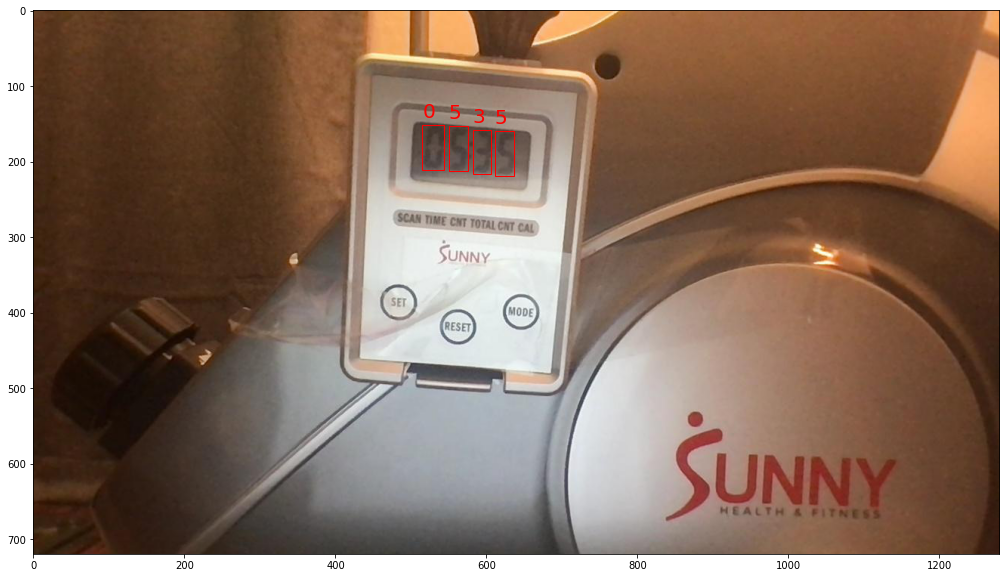

image 1/1 /content/drive/MyDrive/Coding/ModelAssistedLabel/Image Repo/unlabeled/21-3-22 rowing (200) 1:53-7:00/189.jpg: >>> [{'predictions': ['5 0.439453 0.251389 0.0210938 0.0833333 0.881868', '9 0.414453 0.249306 0.0226563 0.0847222 0.882727', '4 0.489844 0.258333 0.021875 0.0833333 0.904524']}]


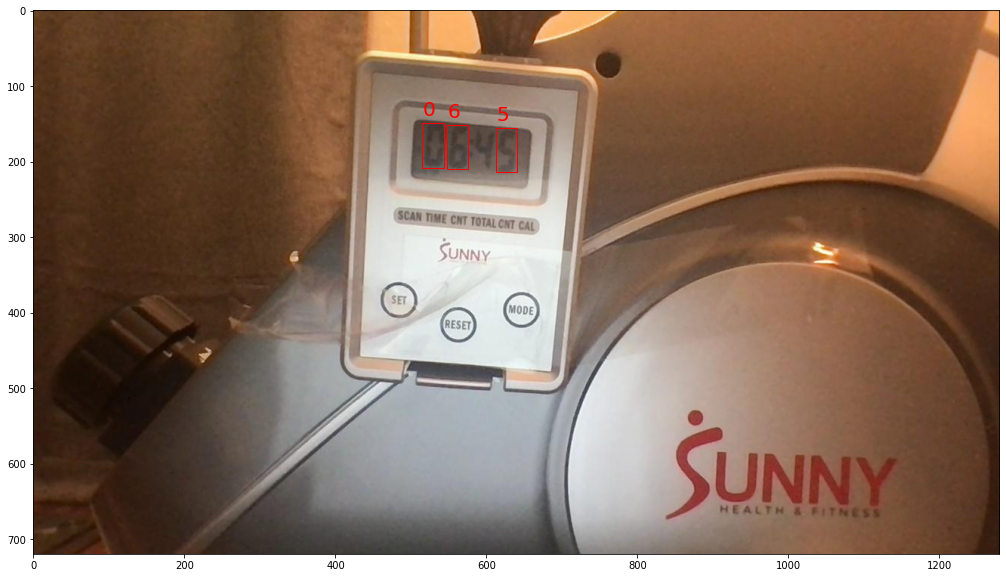

image 1/1 /content/drive/MyDrive/Coding/ModelAssistedLabel/Image Repo/unlabeled/21-3-22 rowing (200) 1:53-7:00/165.jpg: >>> [{'predictions': ['7 0.490625 0.260417 0.021875 0.0819444 0.686349', '9 0.464844 0.257639 0.0234375 0.0819444 0.766056', '9 0.414453 0.249306 0.0226563 0.0847222 0.892554', '5 0.439844 0.252083 0.021875 0.0847222 0.896628']}]


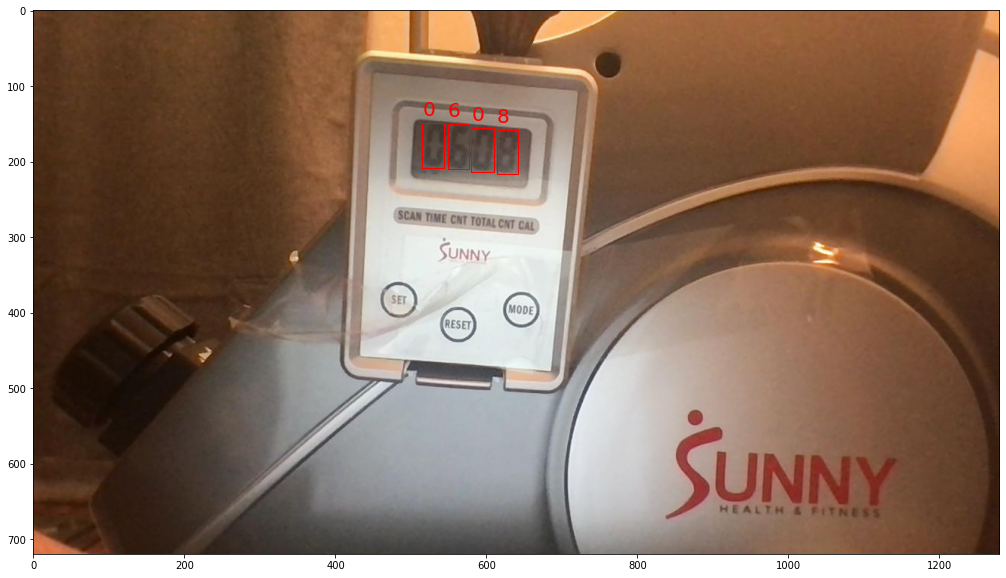

In [ ]:
%matplotlib inline 
import random, glob

images = glob.glob(f"./{unlabeled_images}/*.jpg")

for image in random.sample(images,5):
  v.plot_for(image)

In [ ]:
results = []
for image in images:
  results.append(v.predict_for(image))

image 1/1 /content/drive/MyDrive/Coding/ModelAssistedLabel/Image Repo/unlabeled/21-3-22 rowing (200) 1:53-7:00/7.jpg: image 1/1 /content/drive/MyDrive/Coding/ModelAssistedLabel/Image Repo/unlabeled/21-3-22 rowing (200) 1:53-7:00/13.jpg: >>> [{'predictions': ['0 0.0363281 0.28125 0.0664062 0.556944 0.414134']}]
image 1/1 /content/drive/MyDrive/Coding/ModelAssistedLabel/Image Repo/unlabeled/21-3-22 rowing (200) 1:53-7:00/11.jpg: image 1/1 /content/drive/My Drive/Coding/ModelAssistedLabel/Image Repo/unlabeled/21-3-22 rowing (200) 1:53-7:00/19.jpg: image 1/1 /content/drive/My Drive/Coding/ModelAssistedLabel/Image Repo/unlabeled/21-3-22 rowing (200) 1:53-7:00/6.jpg: image 1/1 /content/drive/My Drive/Coding/ModelAssistedLabel/Image Repo/unlabeled/21-3-22 rowing (200) 1:53-7:00/25.jpg: image 1/1 /content/drive/My Drive/Coding/ModelAssistedLabel/Image Repo/unlabeled/21-3-22 rowing (200) 1:53-7:00/9.jpg: >>> [{'predictions': ['0 0.0339844 0.274306 0.0664062 0.509722 0.477815']}]
image 1/1 /cont

## Exporting annotated images

Store the class labels with index 0 on line 1, index 1 on line 2, and so on.

In [ ]:
with open(os.path.join(export_folder, "label_map.txt"), "w") as label_map:
  label_map.writelines("\n".join(class_idx))

Ensure that image/label pairs have a common root filename

In [ ]:
import random, PIL, shutil
salt = lambda: str(random.random())[2:]

for result in results:
  #generate a likely-to-be-unique filename
  shared_root = Defaults._itername(f"{project_name}-{salt()}")

  #save the image to the outfile
  image = PIL.Image.open(result["image path"])
  image.save(os.path.join(export_folder, "images", f"{shared_root}.jpg"))

  #save the predictions to the outfile
  predictions = result["predictions"]
  with open(os.path.join(export_folder, "labels", f"{shared_root}.txt"), "w") as prediction_file:
    prediction_file.writelines("\n".join([x["yolov5 format"] for x in predictions]))

#check if weights were generated
if aw is not None and os.path.exists(aw.last_results_path):
  print(f"Moving yolov5 results folder: {aw.last_results_path}")
  shutil.move(aw.last_results_path, export_folder)
else:
  print("No weights to save")

No weights to save


At this point I would have uploaded this set of image/label pairs to Roboflow for correction and annotation. As the model grows more accurate, I would alter camera position or lighting until the model started stumbling again. I want to be keeping the model on its toes!

To be transparent, I developed a [custom React annotator](https://github.com/PhilBrockman/autobbox) that better suited my needs.

I labeled dozens upon dozens and dozens of images with Roboflow and would recommend their free annotation service! 

## Wrap up

My original goal of "smartifying" my rowing machine is closer than ever. 

It is possible to parse workout information (thought currently, I only have access to a maximum of 4 digits). I wonder if the model could keep up if there were 20+ digits to capture.

I know that lighting and camera position have an effect on accuracy. Here's how I'm holding my computer steady as I modify the lighting: [standing](https://raw.githubusercontent.com/PhilBrockman/ModelAssistedLabel/master/DIY-laptop-mount.jpg), [floor 1](https://raw.githubusercontent.com/PhilBrockman/ModelAssistedLabel/master/DIY-computer-capture.jpg), [floor 2](https://github.com/PhilBrockman/ModelAssistedLabel/blob/master/DIY-capture.jpeg?raw=true).

Here are 3 runs captured under different lighting conditions:
* `21-3-22 rowing (200) 7:50-12:50` (direct lighting from one light source)
* `21-3-22 rowing (200) 1:53-7:00` (direct lighting from one light source with glare)
* `21-3-18 rowing 8-12 ` (direct light and ambient lamps turned on)

> Note:  All unlabeled images were taken inside a blacked-out room. The are stored in `Image Repo/unlabeled/`






### Parting Questions

My labeled images are disorderly. There's data from other rowing machines and from [a kind stranger's github repo](https://github.com/SachaIZADI/Seven-Segment-OCR). Some images have been cropped to only include the display. Did having varied data slow me down overall? Or did it make the models more robust? 
